# Outlier Detection and Analysis (Numeric Variables Only)
Comprehensive outlier analysis for continuous numeric variables only. Excludes binary and categorical variables.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_parquet('../data/nhanes_data/NHANES_types_defined.parquet')

print("=" * 80)
print("OUTLIER DETECTION AND ANALYSIS (NUMERIC VARIABLES ONLY)")
print("=" * 80)

# Variables to EXCLUDE: Binary and Categorical
exclude_vars = [
    'subject_id', 'diabetes_risk',  # ID and target
    'smoker', 'liver_disease', 'heart_disease', 'hypertension',  # Binary
    'gender', 'ethnicity', 'income_poverty_ratio'  # Categorical
]

# Select ONLY continuous numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_vars]

print(f"\nAnalyzing {len(numeric_cols)} continuous numeric variables for outliers")
print(f"Variables: {numeric_cols}\n")

OUTLIER DETECTION AND ANALYSIS (NUMERIC VARIABLES ONLY)

Analyzing 13 continuous numeric variables for outliers
Variables: ['creatinine', 'bmi', 'waist_cm', 'weight_kg', 'height_cm', 'BPX_SYS', 'BPX_DIA', 'age_years', 'glucose_value', 'hdl_cholesterol', 'SLQ', 'total_cholesterol', 'TRIGLY']



## 1. IQR Method (Interquartile Range)
Outliers = values beyond Q1-1.5×IQR or Q3+1.5×IQR

In [3]:
print("-" * 80)
print("1. IQR METHOD (Outliers = values beyond Q1-1.5*IQR or Q3+1.5*IQR)")
print("-" * 80)

outliers_iqr = {}

for col in numeric_cols:
    if col not in df.columns:
        continue
    
    # Remove NaN for calculation
    data = df[col].dropna()
    
    if len(data) == 0:
        continue
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    outlier_pct = (outliers / len(data)) * 100 if len(data) > 0 else 0
    
    print(f"\n{col}:")
    print(f"  Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"  IQR bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {outliers} ({outlier_pct:.2f}%)")
    
    if outliers > 0:
        # Show outlier values
        outlier_values = data[(data < lower_bound) | (data > upper_bound)]
        print(f"  Min: {data.min():.2f}, Max: {data.max():.2f}")
        print(f"  Outlier range: [{outlier_values.min():.2f}, {outlier_values.max():.2f}]")
        
        outliers_iqr[col] = {
            'count': outliers,
            'pct': outlier_pct,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'data_min': data.min(),
            'data_max': data.max(),
        }
    else:
        print(f"  ✓ No outliers detected")

print(f"\n" + "=" * 80)
if outliers_iqr:
    print(f"✓ {len(outliers_iqr)} variable(s) with outliers (IQR method)")
else:
    print(f"✓ No outliers found using IQR method")

--------------------------------------------------------------------------------
1. IQR METHOD (Outliers = values beyond Q1-1.5*IQR or Q3+1.5*IQR)
--------------------------------------------------------------------------------

creatinine:
  Q1=0.68, Q3=0.98, IQR=0.30
  IQR bounds: [0.23, 1.43]
  Outliers: 949 (2.75%)
  Min: 0.16, Max: 17.41
  Outlier range: [0.16, 17.41]

bmi:
  Q1=23.50, Q3=32.40, IQR=8.90
  IQR bounds: [10.15, 45.75]
  Outliers: 972 (2.77%)
  Min: 11.10, Max: 92.30
  Outlier range: [45.80, 92.30]

waist_cm:
  Q1=84.00, Q3=108.20, IQR=24.20
  IQR bounds: [47.70, 144.50]
  Outliers: 387 (1.14%)
  Min: 53.60, Max: 187.50
  Outlier range: [144.60, 187.50]

weight_kg:
  Q1=63.80, Q3=91.90, IQR=28.10
  IQR bounds: [21.65, 134.05]
  Outliers: 840 (2.39%)
  Min: 24.70, Max: 254.30
  Outlier range: [134.10, 254.30]

height_cm:
  Q1=159.20, Q3=173.60, IQR=14.40
  IQR bounds: [137.60, 195.20]
  Outliers: 70 (0.20%)
  Min: 123.10, Max: 204.50
  Outlier range: [123.10, 204.50]


## 2. Z-Score Method
Outliers = |z-score| > 3 (extreme values beyond 3 standard deviations)

In [4]:
print("\n" + "=" * 80)
print("2. Z-SCORE METHOD (Outliers = |z-score| > 3)")
print("=" * 80)

outliers_zscore = {}

for col in numeric_cols:
    if col not in df.columns:
        continue
    
    data = df[col].dropna()
    
    if len(data) == 0:
        continue
    
    z_scores = np.abs(stats.zscore(data))
    outliers = (z_scores > 3).sum()
    outlier_pct = (outliers / len(data)) * 100 if len(data) > 0 else 0
    
    print(f"\n{col}:")
    print(f"  Outliers (|z| > 3): {outliers} ({outlier_pct:.2f}%)")
    
    if outliers > 0:
        outlier_data = data[z_scores > 3]
        print(f"  Outlier range: [{outlier_data.min():.2f}, {outlier_data.max():.2f}]")
        
        outliers_zscore[col] = {
            'count': outliers,
            'pct': outlier_pct,
            'min_outlier': outlier_data.min(),
            'max_outlier': outlier_data.max(),
        }
    else:
        print(f"  ✓ No extreme outliers")

print(f"\n" + "=" * 80)
if outliers_zscore:
    print(f"✓ {len(outliers_zscore)} variable(s) with extreme outliers (Z-score method)")
else:
    print(f"✓ No extreme outliers found using Z-score method")


2. Z-SCORE METHOD (Outliers = |z-score| > 3)

creatinine:
  Outliers (|z| > 3): 224 (0.65%)
  Outlier range: [2.20, 17.41]

bmi:
  Outliers (|z| > 3): 423 (1.21%)
  Outlier range: [50.80, 92.30]

waist_cm:
  Outliers (|z| > 3): 186 (0.55%)
  Outlier range: [150.60, 187.50]

weight_kg:
  Outliers (|z| > 3): 404 (1.15%)
  Outlier range: [147.80, 254.30]

height_cm:
  Outliers (|z| > 3): 41 (0.12%)
  Outlier range: [123.10, 204.50]

BPX_SYS:
  Outliers (|z| > 3): 364 (1.10%)
  Outlier range: [52.00, 238.00]

BPX_DIA:
  Outliers (|z| > 3): 294 (0.89%)
  Outlier range: [0.00, 142.00]

age_years:
  Outliers (|z| > 3): 0 (0.00%)
  ✓ No extreme outliers

glucose_value:
  Outliers (|z| > 3): 874 (2.46%)
  Outlier range: [8.90, 17.80]

hdl_cholesterol:
  Outliers (|z| > 3): 346 (1.00%)
  Outlier range: [5.00, 226.00]

SLQ:
  Outliers (|z| > 3): 13 (0.04%)
  Outlier range: [14.50, 99.00]

total_cholesterol:
  Outliers (|z| > 3): 234 (0.67%)
  Outlier range: [310.00, 813.00]

TRIGLY:
  Outliers (

## 3. Boxplot Visualization
Visual inspection of outliers for each numeric variable


3. BOXPLOT VISUALIZATION


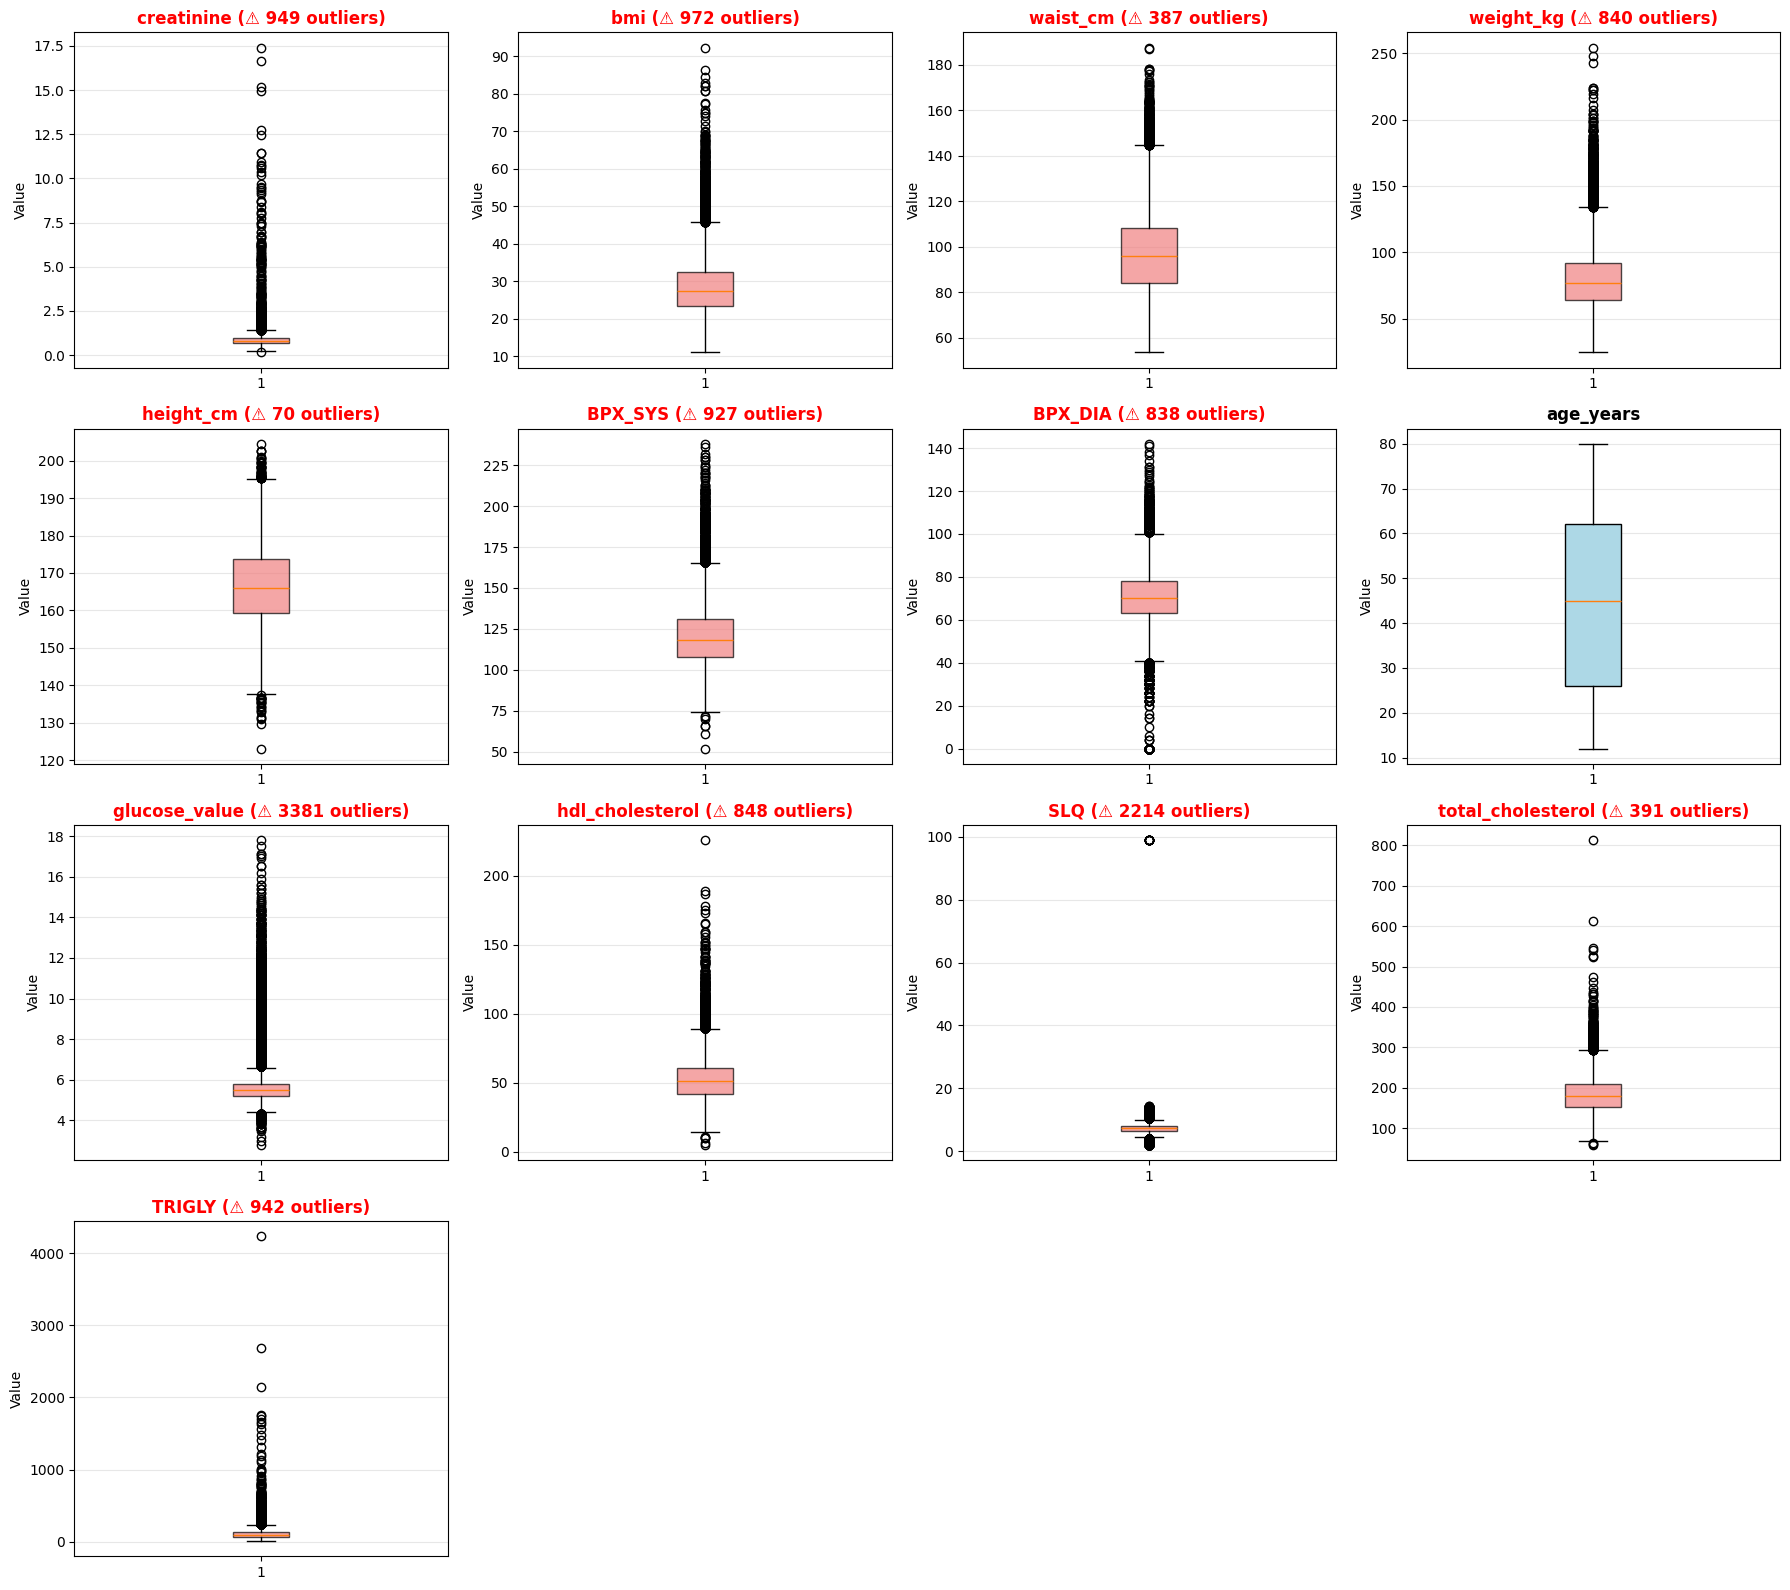

In [18]:
print("\n" + "=" * 80)
print("3. BOXPLOT VISUALIZATION")
print("=" * 80)

# Create subplots for boxplots
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    if col not in df.columns:
        continue
    
    ax = axes[idx]
    
    # Boxplot
    bp = ax.boxplot(df[col].dropna(), vert=True, patch_artist=True)
    
    # Color boxes differently if outliers exist
    if col in outliers_iqr:
        bp['boxes'][0].set_facecolor('lightcoral')
        bp['boxes'][0].set_alpha(0.7)
        ax.set_title(f"{col} (⚠ {outliers_iqr[col]['count']} outliers)", 
                     color='red', fontweight='bold')
    else:
        bp['boxes'][0].set_facecolor('lightblue')
        ax.set_title(col, fontweight='bold')
    
    ax.set_ylabel('Value')
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

## 4. Summary and Recommendations

In [17]:
print("\n" + "=" * 80)
print("OUTLIER ANALYSIS SUMMARY")
print("=" * 80)

variables_with_outliers = set(outliers_iqr.keys()) | set(outliers_zscore.keys())

if variables_with_outliers:
    print(f"\n⚠ Variables with notable outliers: {len(variables_with_outliers)}")
    for col in sorted(variables_with_outliers):
        iqr_info = outliers_iqr.get(col)
        zscore_info = outliers_zscore.get(col)
        
        print(f"\n  {col}:")
        if iqr_info:
            print(f"    - IQR method: {iqr_info['count']} outliers ({iqr_info['pct']:.2f}%)")
        if zscore_info:
            print(f"    - Z-score method (|z|>3): {zscore_info['count']} outliers ({zscore_info['pct']:.2f}%)")
    


OUTLIER ANALYSIS SUMMARY

⚠ Variables with notable outliers: 12

  BPX_DIA:
    - IQR method: 838 outliers (2.54%)
    - Z-score method (|z|>3): 294 outliers (0.89%)

  BPX_SYS:
    - IQR method: 927 outliers (2.81%)
    - Z-score method (|z|>3): 364 outliers (1.10%)

  SLQ:
    - IQR method: 2214 outliers (6.86%)
    - Z-score method (|z|>3): 13 outliers (0.04%)

  TRIGLY:
    - IQR method: 942 outliers (5.54%)
    - Z-score method (|z|>3): 194 outliers (1.14%)

  bmi:
    - IQR method: 972 outliers (2.77%)
    - Z-score method (|z|>3): 423 outliers (1.21%)

  creatinine:
    - IQR method: 949 outliers (2.75%)
    - Z-score method (|z|>3): 224 outliers (0.65%)

  glucose_value:
    - IQR method: 3381 outliers (9.51%)
    - Z-score method (|z|>3): 874 outliers (2.46%)

  hdl_cholesterol:
    - IQR method: 848 outliers (2.44%)
    - Z-score method (|z|>3): 346 outliers (1.00%)

  height_cm:
    - IQR method: 70 outliers (0.20%)
    - Z-score method (|z|>3): 41 outliers (0.12%)

  total

## 5. Filter rows with clinically suspicious extreme values

In [ ]:
mask = (
    (df["bmi"] > 90) |
    (df["total_cholesterol"] > 800) |
    (df["TRIGLY"] > 4000) |
    (df["BPX_SYS"] < 60) |
    (df["BPX_DIA"] < 40)
)

df_extremos = df[mask].sort_index()
print(df_extremos.to_string())

       subject_id  creatinine   bmi  waist_cm  weight_kg  height_cm  hypertension  BPX_SYS  BPX_DIA  age_years  gender  ethnicity  income_poverty_ratio  glucose_value  hdl_cholesterol  liver_disease  heart_disease   SLQ  smoker  total_cholesterol  TRIGLY  diabetes_risk
2         62163.0        0.65  17.3      64.6       49.4      168.9             0    112.0     38.0         14     1.0        5.0                  4.07            5.5             44.0              0              0   NaN       0              154.0     NaN              0
192       62353.0        0.99  27.8     105.4       79.2      168.9             1    110.0     32.0         80     1.0        3.0                  5.00            7.8             39.0              0              0   7.0       1              120.0    68.0              1
488       62649.0        1.56  36.6     118.8      107.0      170.9             1    120.0     38.0         76     1.0        4.0                  2.59            6.0             48.0       

In [ ]:
# Discard DIA = 0 for clear view --> Using NaN instead
mask = (
    (df["bmi"] > 90) |
    (df["total_cholesterol"] > 800) |
    (df["TRIGLY"] > 4000) |
    (df["BPX_SYS"] < 60) 
)

df_extremos = df[mask].sort_index()
print(df_extremos.to_string())

       subject_id  creatinine   bmi  waist_cm  weight_kg  height_cm  hypertension  BPX_SYS  BPX_DIA  age_years  gender  ethnicity  income_poverty_ratio  glucose_value  hdl_cholesterol  liver_disease  heart_disease  SLQ  smoker  total_cholesterol  TRIGLY  diabetes_risk
16368     80169.0        0.64  36.1     113.3       97.4      164.3             0    124.0     70.0         42     2.0        2.0                  2.33            8.2             41.0              0              0  7.0       0              612.0  4233.0              1
17346     81147.0        0.30  38.0     124.4      101.0      163.0             1    116.0     68.0         46     2.0        3.0                  4.06            9.8             59.0              0              0  6.0       1              813.0     NaN              1
42810    122171.0        0.65  92.3       NaN      254.3      166.0             1      NaN      NaN         34     2.0        4.0                  0.38            5.7             50.0          